<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Process-MIRI" data-toc-modified-id="Process-MIRI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Process MIRI</a></span></li><li><span><a href="#MAST-query" data-toc-modified-id="MAST-query-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MAST query</a></span></li><li><span><a href="#pre-fetch-files-for-global-skyflat" data-toc-modified-id="pre-fetch-files-for-global-skyflat-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>pre-fetch files for global skyflat</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-for-headers" data-toc-modified-id="Preprocessing-for-headers-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preprocessing for headers</a></span></li><li><span><a href="#Make-flats-by-filter" data-toc-modified-id="Make-flats-by-filter-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Make flats by filter</a></span></li></ul></li><li><span><a href="#Run-pipeline-by-filter" data-toc-modified-id="Run-pipeline-by-filter-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run pipeline by filter</a></span></li><li><span><a href="#Combine-into-final-mosaics" data-toc-modified-id="Combine-into-final-mosaics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Combine into final mosaics</a></span><ul class="toc-item"><li><span><a href="#HST-mosaics" data-toc-modified-id="HST-mosaics-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>HST mosaics</a></span></li></ul></li><li><span><a href="#Catalog" data-toc-modified-id="Catalog-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Catalog</a></span></li></ul></div>

# Process MIRI

Process MIRI exposures in preliminary PRIMER visits

In [1]:
# Work space, can be elsewhere
import os
import glob

if os.path.exists('/GrizliImaging'):
    WORKING_DIRECTORY = '/GrizliImaging/PrimerMiri'
else:
    WORKING_DIRECTORY = os.getcwd()

print('WORKING_DIRECTORY = ', WORKING_DIRECTORY)

if not os.path.exists(WORKING_DIRECTORY):
    os.makedirs(WORKING_DIRECTORY)
    
os.chdir(WORKING_DIRECTORY)

WORKING_DIRECTORY =  /GrizliImaging/PrimerMiri


In [2]:
# Grizli
import importlib
import sys

# Grizli and requirements, e.g., on google collab
try:
    import grizli
except:
    ! git clone https://github.com/gbrammer/grizli.git
    os.chdir('grizli')
    ! pip install -e ./ -r requirements.txt
    
    ! pip install pytest
    # Fetches config files
    ! pytest --disable-warnings
    
    os.chdir(WORKING_DIRECTORY)
    
## Module versions
print(sys.version + '\n')

for module in ['grizli', 'tristars', 'mastquery', 'sep',
               'numpy', 'scipy', 'astropy', 'astroquery', 
               'shapely', 'drizzlepac']:
    #print(module)
    try:
        mod = importlib.import_module(module)
        print('{0:>20} : {1}'.format(module, mod.__version__))
    except ModuleNotFoundError:
        print('{0:>20} : {1}'.format(module, '*failed*'))

3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:52) 
[Clang 13.0.1 ]

              grizli : 1.6.0.dev58
            tristars : 0.1
           mastquery : 1.4
                 sep : 1.2.1
               numpy : 1.23.1
               scipy : 1.9.0
             astropy : 5.1
          astroquery : 0.4.6
             shapely : 1.8.2


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
          drizzlepac : 3.4.2


In [3]:
try:
    import jwst
except ModuleNotFoundError:
    ! pip install jwst

if os.getenv('CRDS_PATH') is None:
    cache_dir = os.path.join(os.getcwd(), 'crds_cache')
    print(f'Set CRDS_PATH={cache_dir}')
    os.environ['CRDS_PATH'] = cache_dir
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
else:
    print(f"CRDS_PATH={os.getenv('CRDS_PATH')}")

if os.getenv('CRDS_SERVER_URL') is None:
    server = 'https://jwst-crds.stsci.edu'
    print(f'Set CRDS_SERVER_URL={server}')
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
else:
    print(f"CRDS_SERVER_URL={os.getenv('CRDS_SERVER_URL')}")


CRDS_PATH=/Users/gbrammer/Research/grizli/crds_cache
CRDS_SERVER_URL=https://jwst-crds.stsci.edu


In [4]:
import numpy as np
import astropy.units as u

import mastquery
from mastquery import overlaps, query, jwst
import astropy.time

from importlib import reload
reload(jwst)

import grizli
from grizli import utils, jwst_utils
from grizli.aws import db

utils.set_warnings()
jwst_utils.set_quiet_logging()

import logging
logging.basicConfig(level=logging.INFO,
                    handlers=[logging.StreamHandler(),
                              logging.FileHandler('/tmp/mastquery.log')], 
                    format = "%(module)s.%(funcName)s : %(levelname)s : %(message)s")

# MAST query

In [5]:
# General query
filters = []
filters += jwst.make_query_filter('productLevel', values=['2a','2b'])

if 1:
    # PRIMER MIRI
    filters += jwst.make_program_filter([1837]) 
    filters += jwst.make_query_filter('filter', values=['F770W','F1800W'])
else:
    # CEERS MIRI
    filters += jwst.make_program_filter([1345]) 
    filters += jwst.make_query_filter('filter', values=['F560W','F770W','F1000W','F1130W',
                                                        'F1280W','F1500W','F1800W','F2100W'][1:2])
    
res = jwst.query_all_jwst(instruments=['MIR','NRC','NIS','NRS'],
                          recent_days=None, filters=filters, columns='*',
                          extensions=['rate','cal', 'rateints'])


jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : Available extensions are []
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : Available extensions are []
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : Available extensions are []


In [6]:
# Some fixes to the query

# No spaces in target names
res['targname'] = [t.replace(' ','-') for t in res['targname']]
res['target'] = [t.replace(' ','-') for t in res['target']]
res = res[np.in1d(res['instrument_name'], ['NIRISS','NIRCAM','MIRI'])]

# No MIRI spec
res = res[res['inst-mode'] != 'MIRI-None']
res = res[res['targname'] != 'MIRI-SLEW-TO-HOT-TARGET-NORTH']

# Just get rate images
for k in ['dataURI','dataURL']:
    col = res[k].tolist()
    for i, val in enumerate(col):
        col[i] = val.replace('_cal.fits','_rate.fits').replace('_rateints','_rate')
    
    res.remove_column(k)
    res[k] = col

# Unique filename, since could have found cal and rate files for the same dataset
un = utils.Unique(res['dataURL'], verbose=False)

keep = res['exptime'] > 0
for i in np.where(np.array(un.counts) > 1)[0]:
    vi = un.values[i]
    j = np.where(un[vi])[0][1:]
    keep[j] = False

# Skip some modes
mask_mode = utils.column_string_operation(res['inst-mode'], ['MASK','WLP',
                                                             'FND','P750L',
                                                             '1065C','2100C','2300C','1550C','1140C',
                                                             #'GR1','GRIS',
                                                             'W2',
                                                             'GR700','MP','WP','NRM',
                                                             'F212N'],
                                          method='count')
keep &= ~mask_mode

if 0:
    keep &= res['instrument_name'] == 'NIRCAM'
    
res = res[keep]
len(res)

24

In [7]:
# Query summary
import yaml
from grizli import utils

pi = utils.Unique(res['prog_pi'])
pi.exptime = np.array([res['effexptm'][pi[p]].sum() for p in pi.values])

js = {}

for ii in np.argsort(pi.counts):
    p = pi.values[ii]
    targs = np.unique(res['targname'][pi[p]])
    modes = np.unique(res['inst-mode'][pi[p]])
    js[str(p)] = {'N':int(pi.counts[ii]),
             'title': str(res['title'][pi[p]][0].strip()), 
             'targets': [str(t).strip() for t in targs],
             'modes': [str(t).strip() for t in modes]}
    
    print(f"\n ({js[p]['N']}) {p}  | \"{js[p]['title']}\"")
    print(f"   Targets:  {', '.join(js[p]['targets'])}")
    print(f"   Modes:    {', '.join(js[p]['modes'])}")

   N  value     
====  ==========
  24    GO-1837 Dunlop, James S.

 (24)   GO-1837 Dunlop, James S.  | "PRIMER: Public Release IMaging for Extragalactic Research"
   Targets:  
   Modes:    MIRI-F1800W, MIRI-F770W


Iter #1, N_Patch = 1


 1 j021732m0517 34.3795145 -5.2775248333333336
target
------
       

filter j021732m0517        MIRI MI.F1800W   12    5361.4
filter j021732m0517         MIRI MI.F770W   12    5328.1


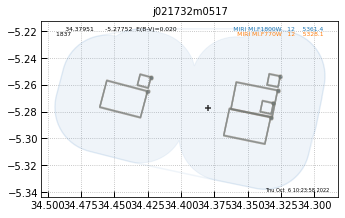

In [8]:
# Split into overlapping fields
import os
import mastquery.utils
reload(mastquery.utils); reload(overlaps)

os.chdir(WORKING_DIRECTORY)

# Single group to process together
tabs = overlaps.find_overlaps(res, use_parent=True, buffer_arcmin=2, close=False)

# pre-fetch files for global skyflat

Download `rate` files 

In [11]:
#root = 'j021732m0517'
#root = 'j142008p5256'
root = tabs[0].meta['NAME']

os.chdir(WORKING_DIRECTORY)

if not os.path.exists(root):
    os.mkdir(root)
    
os.chdir(os.path.join(WORKING_DIRECTORY, root))
for d in ['RAW','Prep']:
    if not os.path.exists(d):
        os.mkdir(d)
        print(d)
        
os.chdir(os.path.join(WORKING_DIRECTORY, root, 'RAW'))

# Requires MAST_TOKEN environment variable to be set
# see https://auth.mast.stsci.edu/token
mastquery.utils.download_from_mast(res)

{'jw01837022001_02101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_02101_00002_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_04101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_04101_00002_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_06101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_06101_00002_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_08101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837022001_08101_00002_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837014001_02101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837014001_02101_00002_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837014001_04101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837014001_04101_00002_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837014001_06101_00001_mirimage_rate.fits': ('EXISTS', None, None),
 'jw01837014001_06101_00002_mirimage_rate.fits': ('

## Preprocessing for headers

0. The script downloads `rate.fits` uncalibrated ramp files
1. Run `AssignWcsStep` and derive improved SIP WCS headers
2. Run `FlatFieldStep` and `PhotomStep` manually 
3. Set DQ bit around image FOV and coronagraph

In [12]:
from grizli import prep

# Explicitly set CRDS_CONTEXT
os.environ['CRDS_CONTEXT'] = 'jwst_0988.pmap'

os.chdir(os.path.join(WORKING_DIRECTORY, root, 'RAW'))

files = glob.glob('*rate.fits')
files.sort()

os.chdir(os.path.join(WORKING_DIRECTORY, root, 'Prep'))

for file in files:
    if not os.path.exists(file):
        prep.fresh_flt_file(file)

## Make flats by filter

In [16]:
# Group by filter
import astropy.io.fits as pyfits
from grizli.aws import visit_processor
res = visit_processor.res_query_from_local()

keys = ['readpatt']
cols = {}
for k in keys:
    cols[k] = []

for d in res['dataset']:
    im = pyfits.open(f'{d}_rate.fits')
    for k in keys:
        cols[k].append(im[0].header[k])

for k in keys:
    res[k] = cols[k]
    
res['mode'] = [f'{f}-{p}-{d[3:7]}' for f, p, d in zip(res['filter'], res['readpatt'], res['dataset'])]

un = utils.Unique(res['mode'])

visits = []
print('\nVisits:')
for i, f in enumerate(un.values):
    ix = un[f]
    files = [f'{d}_rate.fits' for d in res['dataset'][un[f]]]
    visit = {'product':f'miri-{f.lower()}', 'files':files}
    visits.append(visit)
    print(i, visit['product'])

   N  value     
====  ==========
  12  F1800W-FASTR1-1837
  12  F770W-FASTR1-1837

Visits:
0 miri-f1800w-fastr1-1837
1 miri-f770w-fastr1-1837


In [17]:
flat_files = {}
for visit in visits:
    flat_file = f"{visit['product']}_skyflat.fits"
    if not os.path.exists(flat_file):
        prep.make_visit_average_flat(visit, clip_max=0, threshold=5, dilate=3, apply=False)
    else:
        print(f'{flat_file} found')
    
    im = pyfits.open(flat_file)
    flat_files[im[0].header['filter']] = flat_file

print(flat_files)

miri-f1800w-fastr1-1837_skyflat.fits found
miri-f770w-fastr1-1837_skyflat.fits found
{'F1800W': 'miri-f1800w-fastr1-1837_skyflat.fits', 'F770W': 'miri-f770w-fastr1-1837_skyflat.fits'}


In [18]:
! cp *skyflat.fits {WORKING_DIRECTORY}/

# Run pipeline by filter

In [19]:
from grizli.pipeline import auto_script
kws = auto_script.get_yml_parameters()

# Stop after exposure preprocessing
kws['kill'] = 'preprocess'

# Use database astrometry reference (HSC catalog for UDS)
kws['preprocess_args']['master_radec'] = 'astrometry_db'

In [20]:
os.chdir(WORKING_DIRECTORY)
! ls 

j021732m0517                         j142008p5256_footprint.fits
j021732m0517.auto_script.log.txt     j142008p5256_footprint.pdf
j021732m0517_footprint.fits          j142008p5256_footprint.yaml
j021732m0517_footprint.pdf           j142008p5256_info.dat
j021732m0517_footprint.yaml          miri-f1800w-fastr1-1837_skyflat.fits
j021732m0517_info.dat                miri-f770w-fastr1-1837_skyflat.fits
j142008p5256                         miri-f770w-slowr1-1345_skyflat.fits
j142008p5256.auto_script.log.txt     overlaps.yaml


In [21]:
os.chdir(WORKING_DIRECTORY)

kws['fetch_files_args'] = None

# Don't do fine alignment for MIRI, which fails on redder bands with few sources
miri_prep = dict(run_tweak_align=False,
                 align_mag_limits=[14,28,0.2],
                 align_clip=20, 
                 align_simple=True)

for k in miri_prep:
    kws['visit_prep_args'][k] = miri_prep[k]

filters = np.unique(res['filter'])

for filt in flat_files:
    os.chdir(WORKING_DIRECTORY)

    kws['filters'] = [filt]
    kws['visit_prep_args']['miri_skyfile'] = f"{WORKING_DIRECTORY}/{flat_files[filt]}"
    
    auto_script.go(root, **kws)

# (2022-10-06 08:27:07.770)

auto_script.parse_visits(**{'files': [], 'field_root': 'j021732m0517', 'RAW_PATH': '/GrizliImaging/PrimerMiri/j021732m0517/RAW', 'use_visit': True, 'combine_same_pa': False, 'combine_minexp': 2, 'is_dash': False, 'filters': ['F1800W'], 'max_dt': 1.0, 'visit_split_shift': 1.5, 'file_query': '*'})

indef-01837-022-250.0-F1800W 4
indef-01837-014-253.0-F1800W 4
indef-01837-023-254.0-F1800W 4
** Combine Singles: **
0 indef-01837-022-250.0-f1800w 4
1 indef-01837-014-253.0-f1800w 4
2 indef-01837-023-254.0-f1800w 4

 == Grism groups ==

# (2022-10-06 08:27:08.082)

auto_script.preprocess(**{'field_root': 'j021732m0517', 'HOME_PATH': '/GrizliImaging/PrimerMiri', 'PERSIST_PATH': '/GrizliImaging/PrimerMiri/j021732m0517/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': 'astrometry_db', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True

# Combine into final mosaics

In [22]:
import glob
import astropy.wcs as pywcs
from grizli.aws import visit_processor

files = glob.glob('*rate.fits')
files.sort()

miri_pixscale = 0.1

hdu = utils.make_maximal_wcs(files=files, pixel_scale=miri_pixscale,
                             pad=4, theta=0, verbose=True)

wcs = pywcs.WCS(hdu.header)

res = visit_processor.res_query_from_local()

_ = visit_processor.cutout_mosaic(root,
                                  ir_wcs=wcs,
                                  kernel='square', pixfrac=0.8,
                                  clean_flt=False, 
                                  s3output=None,
                                  gzip_output=False,
                                  skip_existing=True,
                                  res=res,
                                  half_optical=False
                                  )


  0/ 24: jw01837014001_02101_00001_mirimage_rate.fits[SCI,1]    3.68
  1/ 24: jw01837014001_02101_00002_mirimage_rate.fits[SCI,1]    3.74
  2/ 24: jw01837014001_04101_00001_mirimage_rate.fits[SCI,1]    3.74
  3/ 24: jw01837014001_04101_00002_mirimage_rate.fits[SCI,1]    3.74
  4/ 24: jw01837014001_06101_00001_mirimage_rate.fits[SCI,1]    3.74
  5/ 24: jw01837014001_06101_00002_mirimage_rate.fits[SCI,1]    3.75
  6/ 24: jw01837014001_08101_00001_mirimage_rate.fits[SCI,1]    3.75
  7/ 24: jw01837014001_08101_00002_mirimage_rate.fits[SCI,1]    3.75
  8/ 24: jw01837022001_02101_00001_mirimage_rate.fits[SCI,1]    7.42
  9/ 24: jw01837022001_02101_00002_mirimage_rate.fits[SCI,1]    7.49
 10/ 24: jw01837022001_04101_00001_mirimage_rate.fits[SCI,1]    7.49
 11/ 24: jw01837022001_04101_00002_mirimage_rate.fits[SCI,1]    7.49
 12/ 24: jw01837022001_06101_00001_mirimage_rate.fits[SCI,1]    7.49
 13/ 24: jw01837022001_06101_00002_mirimage_rate.fits[SCI,1]    7.50
 14/ 24: jw01837022001_08101_00001

## HST mosaics

Contact G. Brammer for access credentials to the db for querying HST/JWST exposures processed with the `grizli` pipeline.

In [ ]:
# HST
_ = visit_processor.cutout_mosaic(root, filters=['F098M','F105W','F110W','F125W','F140W','F160W'],
                                  ir_wcs=wcs,
                                  kernel='square', pixfrac=0.8,
                                  clean_flt=True, 
                                  s3output=None,
                                  gzip_output=False,
                                  skip_existing=True,
                                  half_optical=False
                                  )


In [ ]:
_ = visit_processor.cutout_mosaic(root, filters=['F814W'],
                                  ir_wcs=wcs,
                                  kernel='square', pixfrac=0.8,
                                  clean_flt=True, 
                                  s3output=None,
                                  gzip_output=False,
                                  skip_existing=True,
                                  half_optical=True
                                  )

# Catalog

Make a catalog with matched aperture photometry in HST and MIRI filters

In [ ]:
from grizli.pipeline import auto_script
reload(auto_script)

comb = {'ir':['F125W','F160W','F770W']}

auto_script.make_filter_combinations(root, weight_fnu=2, force_photfnu=1.e-8, filter_combinations=comb)

In [ ]:
auto_script.multiband_catalog(field_root=root, 
                              threshold=1.5,
                              bkg_params={'bw': 50, 'bh': 50,
                                          'fw': 3, 'fh': 3, 'pixel_scale': 0.04},
                              get_all_filters=True,
                              phot_err_scale=1.0)

In [ ]:
! ls *phot.fits

In [ ]:
# Photoz
from grizli.pipeline import photoz
from importlib import reload
reload(photoz)

from grizli import utils
utils.set_warnings()

jwst_trans = {'f115wn-clear':309,
              'f200wn-clear':311,
              'f070w-clear':362,
              'f090w-clear':363,
              'f115w-clear':364,
              'f150w-clear':365,
              'f200w-clear':366,
              #'f212n-clear':374,
              'f277w-clear':375,
              'f300m-clear':380,
              'f356w-clear':376,
              'f410m-clear':383,
              'f444w-clear':377,
              'f480m-clear':386,
              'f115wn':309,
              'f200wn':311,
              'f070w':362,
              'f090w':363,
              'f115w':364,
              'f150w':365,
              'f200w':366,
              'f277w':375,
              'f300m':380,
              'f356w':376,
              'f410m':383,
              'f444w':377,
              'f480m':386,
              'f560w':395,
              'f770w':396,
              'f1000w':397,
              'f1130w':398,
              'f1280w':399,
              'f1500w':400,
              'f1800w':401,
              'f2100w':402,
             }

filter_trans = photoz.FILTER_TRANS
for k in jwst_trans:
    filter_trans[k] = jwst_trans[k]

extra_params = {'TEMPLATES_FILE':'templates/xspline_templates/corr_sfhz_13.param',
                'TEMP_ERR_A2':1.0, 
                'TEMP_ERR_FILE':'templates/template_error_cosmos2020.txt'}

extra_params['TEMPLATES_FILE'] = 'templates/xspline_templates/carnall_sfhz_13.param'

_ = photoz.eazy_photoz(root, object_only=False, beta_prior=False, prior=False,
                       aper_ix=1, z_max=18,
                       filter_trans=filter_trans, 
                       extra_rf_filters = [120, 121, 156, 157, 158, 159, 160,
                                                    414, 415, 416], 
                       force=True, force_apcorr=True, 
                       extra_params=extra_params)

self, cat, zout = _

In [ ]:
import grizli.ds9
ds9 = grizli.ds9.DS9()

In [ ]:
zmax = 11.5
zmin = 9

zra = (9, 11.5)

zra = (0, 2.5)

if 1:
    zra = None

xlim = (0.2, 20)
#xlim = (0.3, 25)

_ = photoz.show_from_ds9(ds9, self, zout, xlim=xlim, show_stars=True, show_components=True)
if zra is not None:
    _[0][0].axes[-1].set_xlim(*zra)

_ = photoz.show_from_ds9(ds9, self, zout, show_fnu=1, xlim=xlim)
if zra is not None:
    _[0][0].axes[-1].set_xlim(*zra)

ix = _[0][1]['ix']

_ra, _dec = self.cat['ra'][ix], self.cat['dec'][ix]

import astropy.time
print('(ra, dec)=', _ra, _dec, '; ', astropy.time.Time.now().iso)
